Welcome to aasignment 1.                                                       

We are using pathology images for our first assignment please download data from this link https://drive.google.com/drive/folders/10dUOzcPR-PQwfFYcHk5gsLjIjSorQ32Q?usp=sharing

In [1]:
import warnings

# To ignore all warnings
warnings.filterwarnings("ignore")



# Task 1: Feature Generation (15%)
# Use and run the following code (a deep network) to generate features from a set of training images. For this assignment, you do not need to know how the deep network is working here to extract features.
# This code extracts the features of image T4.tif (in the T folder of dataset). Modify the code so that it iterates over all images of the dataset and extracts their features.
# Allocate 10% of the data for validation.

# Insert your code here for Task 1





In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models import densenet121
from torch.autograd import Variable
from PIL import Image
import os
import numpy as np

# Load pre-trained DenseNet model
model = densenet121(pretrained=True)

# Remove the classification layer (last fully connected layer)
model = torch.nn.Sequential(*list(model.children())[:-1])

# Add a global average pooling layer
model.add_module('global_avg_pool', torch.nn.AdaptiveAvgPool2d(1))

# Set the model to evaluation mode
model.eval()

# Define the image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Set the path to the dataset folder
dataset_folder = "data"

features_list = list()
labels_list = list()

# Iterate over each subfolder (A to T)
# Subfolder A = label 1, B = label 2, etc. 
for label, subfolder in enumerate(sorted(os.listdir(dataset_folder))):
    subfolder_path = os.path.join(dataset_folder, subfolder)

    # Check if it is a directory
    if os.path.isdir(subfolder_path):
        # List all image files in the subfolder
        image_files = [f for f in os.listdir(subfolder_path) if f.endswith('.tif')]

        # Iterate over each image in the subfolder
        for image_file in image_files:
            image_path = os.path.join(subfolder_path, image_file)

            image = Image.open(image_path)
            input_tensor = preprocess(image)
            input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
            input_var = Variable(input_batch)

            # Forward pass through the model
            features = model(input_var)
            feature_vector = features.squeeze().detach().numpy()

            # Append the feature vector and label to the lists
            features_list.append(feature_vector)
            labels_list.append(label)
        

features_array = np.array(features_list)
labels_array = np.array(labels_list)

# Save features and labels
np.save(file="image_features.npy", arr=features_array)
np.save(file="image_labels.npy", arr=labels_array)

print("Image features shape:", features_array.shape)  # shape (Number of images, Features dim)
print("Image labels shape:", labels_array.shape)  # shape (Number of images,) i.e one label per image


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split ratio (Train, Valid, Test) 80:10:10

features_array = np.load("image_features.npy")
labels_array = np.load("image_labels.npy")

features_train, features_temp, labels_train, labels_temp = train_test_split(
    features_array, labels_array, test_size=0.2, random_state=42)

features_valid, features_test, labels_valid, labels_test = train_test_split(
    features_temp, labels_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting arrays
print("Training set shapes:", features_train.shape, labels_train.shape)
print("Validation set shapes:", features_valid.shape, labels_valid.shape)
print("Test set shapes:", features_test.shape, labels_test.shape)


Training set shapes: (624, 1024) (624,)
Validation set shapes: (78, 1024) (78,)
Test set shapes: (78, 1024) (78,)


# Task 2: High Bias Classification Method (5%)
# Choose a classification method and let is have a high bias.
# Train it on the generated features and discuss why it is underfitting.

# Insert your code here for Task 2




# Task 3: High Variance Classification Method (5%)
# Use the chosen classification method and let it have a high variance.
# Train it on the generated features and discuss why it is overfitting.

# Insert your code here for Task 3




# Task 4: Balanced Classification Method (15%)
# Use the chosen classification method and let it balance the bias and variance.
# Train it on the generated features, possibly adjusting parameters.
# Discuss insights into achieving balance.

# Insert your code here for Task 4




# Task 5: K-Means Clustering (20%)
# Apply K-Means clustering on the generated features.
# Test with available labels and report accuracy.
# Experiment with automated K and compare with manually set 20 clusters.

# Insert your code here for Task 5




#### We start by training a first KMeans model with K=20 (number of classes in our dataset). As the clustering is arbitrary, we need map these clusters ids to the true class labels. To do this, we plot the confusion matrix and we reorder cluster ids using a voting method, i.e, we assign the cluster the label that is most frequent in that cluster.

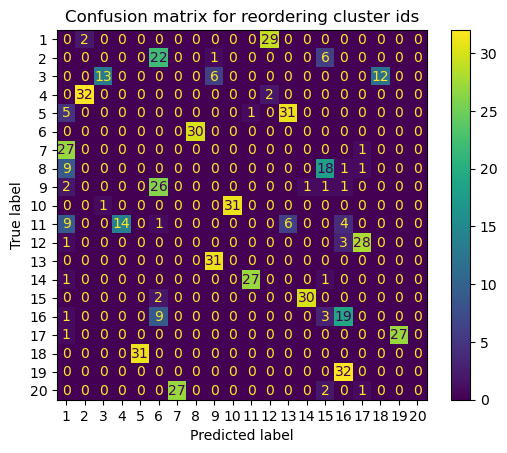

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

n_classes = 20 # number of classes in the dataset
kmeans = KMeans(n_clusters=n_classes, random_state=42)
kmeans.fit(features_train)

predicted_labels_train = kmeans.predict(features_train)

# Confusion matrix for cluster reordering 
ConfusionMatrixDisplay.from_predictions(
    labels_train, 
    predicted_labels_train, 
    labels=np.unique(labels_array)
)

plt.title("Confusion matrix for reordering cluster ids")
plt.show()

In [4]:
import numpy as np
from scipy.stats import mode
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Map cluster ids to true class labels using the majority voting approach
def assign_labels_to_clusters(true_labels: np.ndarray, predicted_clusters: np.ndarray) -> np.ndarray:
    """
    Reorder cluster ids by mapping cluster ids to true labels
    """
    clusters_ids = np.unique(predicted_clusters)
    clusters_reordered = np.zeros_like(predicted_clusters)

    for cluster in clusters_ids:
        mask = (predicted_clusters == cluster)
        majority_label = mode(true_labels[mask], keepdims=True).mode[0]
        clusters_reordered[mask] = majority_label

    return clusters_reordered

clusters_reordered = assign_labels_to_clusters(labels_train, predicted_labels_train)

#### Once the KMeans clusters are reordered to correspond to their corresponding class labels, we can define the clustering accuracy, which is in the case the ratio between the number of correct predictions (knowing the true labels) by the total number of predictions  

In [5]:
def classification_accuracy(true_labels: np.ndarray, predicted_labels: np.ndarray) -> np.ndarray:
    """
    Compute the accuracy of the clustering task in %
    The accuracy of the clustering task is the ratio between the
    number of correct predictions (knowing the true labels) by the total number of predictions 
    """
    correct_predictions = np.sum(np.array(true_labels) == np.array(predicted_labels))
    total_samples = len(true_labels)
    accuracy = (correct_predictions / total_samples) * 100.0
    return accuracy

print(f"The accuracy of the KMeans clustering with K={n_classes} on the train set is: {round(classification_accuracy(labels_train, clusters_reordered),2)} %")

The accuracy of the KMeans clustering with K=20 on the train set is: 79.65 %


#### Then, we experiment different choice of K in order to find the number of clusters that maximizes the accuracy of the clustering task

In [6]:
# Experiment with automated K
k_range = range(1, 21)
best_accuracy = 0
best_k = 0
accuracy_scores = list()

# Iterate over different K values
for k in k_range:
    kmeans_auto = KMeans(n_clusters=k, random_state=42)
    predicted_labels_auto = kmeans_auto.fit_predict(features_train)
    clusters_ids_reorder = assign_labels_to_clusters(labels_train, predicted_labels_auto)
    accuracy = classification_accuracy(labels_train, clusters_ids_reorder)


    # Update best K if the current accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
    accuracy_scores.append(accuracy)

# Report the best automated K and its accuracy
print(f"Best choice of K: {best_k}")
print(f"Accuracy with best K: {round(best_accuracy,2)} %")


Best choice of K: 18
Accuracy with best K: 79.65 %


#### TODO (rephrase) - We plot a sort of "elbow curve" to visually assess the pertinence of the K parameter for the classification accuracy of our clustering task

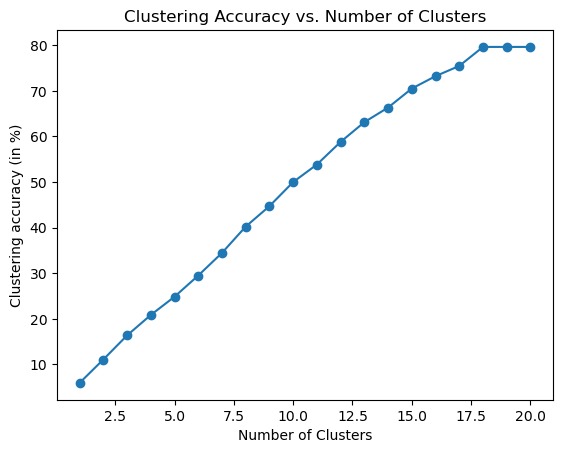

In [7]:
plt.plot(np.unique(predicted_labels_train)+1, accuracy_scores, marker='o')
plt.title('Clustering Accuracy vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Clustering accuracy (in %)')
plt.show()

# Task 6: Additional Clustering Algorithm (10%)
# Choose another clustering algorithm and apply it on the features.
# Test accuracy with available labels.

# Insert your code here for Task 6




In [24]:
from sklearn.cluster import DBSCAN

# TODO - Grid Search on DBSCAN params to find optimal classification accuracy
param_grid = {
    'eps': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'min_samples': [1, 2, 5, 8, 10, 15]
}

dbscan_accuracy = 0
eps_initial = None
min_samples_initial = None

for eps in param_grid["eps"]:
    for min_samples in param_grid["min_samples"]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_clusters = dbscan.fit_predict(features_train)
        reordered_clusters_id = assign_labels_to_clusters(labels_train, dbscan_clusters)
        current_accuracy = classification_accuracy(labels_train, reordered_clusters_id)

        if current_accuracy > dbscan_accuracy:
            dbscan_accuracy = current_accuracy
            eps_initial = eps
            min_samples_initial = min_samples

print("Min sample:", min_samples_initial)
print("Epsilon:", eps)
print(f"DBSCAN clustering accuracy on train set: {dbscan_accuracy} %")

Min sample: 1
Epsilon: 10.0
DBSCAN clustering accuracy on train set: 100.0 %


In [27]:
dbscan = DBSCAN(eps=10, min_samples=1)
dbscan_clusters = dbscan.fit_predict(features_train)
reordered_clusters_id = assign_labels_to_clusters(labels_train, dbscan_clusters)
current_accuracy = classification_accuracy(labels_train, reordered_clusters_id)
current_accuracy

90.7051282051282

#### DBSCABN found 20 classes without any specification on the number of cluster by the user's!

In [28]:
np.unique(reordered_clusters_id)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

# Task 7: PCA for Classification Improvement (20%)
# Apply PCA on the features and then feed them to the best classification method in the above tasks.
# Assess if PCA improves outcomes and discuss the results.

# Insert your code here for Task 7




#### We reduce the dimensionality of our feature space from 1024 to 50 using PCA. We then feed the reduced features into the KMeans with 20 classes for Task 5. We observe that the PCA improves our classification accuracy!

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42) # reduce features space from 1024 to 50 dimensions

# Apply PCA on features from train set
features_train_pca = pca.fit_transform(features_train)

# Train a new KMeans model on these reduced features (dim=50)
kmeans_pca = KMeans(n_clusters=n_classes, random_state=42)
clustered_pca_features = kmeans_pca.fit_predict(features_train_pca)

reordered_clusters_id = assign_labels_to_clusters(labels_train, clustered_pca_features)

pca_accuracy = classification_accuracy(labels_train ,reordered_clusters_id)
print(f"KMeans accuracy after PCA dimensionality reduction: {round(pca_accuracy,2)}%") # Score increases!


# Task 8: Visualization and Analysis (10%)
# Plot the features in a lower dimension using dimentinality reduction techniques.
# Analyze the visual representation, identifying patterns or insights.

# Insert your code here for Task 8

#### In order to visualize our feature space (of dimension 1024), we need to reduce the dimensionality of the features. We do that using tSNE and plot the data in 2D

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Apply t-SNE for dimensionality reduction and visualization
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_train)

# Define the discrete colormap with integer values
cmap_discrete = ListedColormap(plt.cm.tab20.colors[:20])
norm_discrete = BoundaryNorm(range(1, 21), cmap_discrete.N)

# Plot the features in a lower dimension using t-SNE with the discrete colormap
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels_train, cmap=cmap_discrete, alpha=0.7)
plt.title('t-SNE Visualization of Features colored by class labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, ticks=range(1, 21), label='Class Labels')
plt.show()


#### We observe that class 1 and class 4 are very close in this plot, which shows how close they are to each other in the feature space. These two classes probably represent the same pathology or similar pathologies. Moreover, the classes 13, 3 and 10 are quite close to each other, which suggest that they might also represent similar pathologies. 

In [ ]:
clusters_validset = kmeans_pca.predict(pca.transform(features_valid))

reordered_valid_clusters_id = assign_labels_to_clusters(labels_valid, clusters_validset)

validset_accuracy = classification_accuracy(labels_valid, reordered_valid_clusters_id)
print(f"The accuracy on the valid set by using first PCA is : {round(validset_accuracy,2)} %")

In [ ]:
clusters_validset = kmeans.predict(features_valid)

reordered_valid_clusters_id = assign_labels_to_clusters(labels_valid, clusters_validset)

validset_accuracy = classification_accuracy(labels_valid, reordered_valid_clusters_id)
print(f"The accuracy on the valid set is : {round(validset_accuracy,2)} %")